In [212]:
!pip install tqdm
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.datasets.samples_generator import make_moons
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm

np.random.seed(0)

In [213]:
class ActivationFunction:
    name = "base"

    @staticmethod
    def calc(x): return 0

    @staticmethod
    def calc_derivative(x): return 0


class SoftMax(ActivationFunction):
    name = "SoftMax"

    @staticmethod
    def calc(x):
        e_x = np.exp(x)
        return e_x / e_x.sum(axis=0)

    @staticmethod
    def calc_derivative(x):
        s = x.reshape(-1, 1)
        return np.diagflat(s) - np.dot(s, s.T)


class HyperbolicTangent(ActivationFunction):
    name = "Hyperbolic Tangent"

    @staticmethod
    def calc(x):
        return np.tanh(x)

    @staticmethod
    def calc_derivative(x):
        return 1.0 - np.tanh(x)**2


class ReLU(ActivationFunction):
    name = "ReLU"

    @staticmethod
    def calc(x):
        return x * (x > 0)

    @staticmethod
    def calc_derivative(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x
    
class Sigmoid(ActivationFunction):
    name = "Sigmoid"
    
    @staticmethod
    def calc(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def calc_derivative(x):
        return(np.exp(-x))/((1+np.exp(-x))**2)
        


class ErrorFunction:
    name = "base_error"

    @staticmethod
    def calc(target, prediction):
        return 0

    @staticmethod
    def calc_derivative(target, prediction):
        return 0


class SquareRootError(ErrorFunction):
    name = "Root square mean error"

    @staticmethod
    def calc(target, prediction):
        return np.sqrt(((prediction - target) ** 2).mean())

    @staticmethod
    def calc_derivative(target, prediction):
        return


class CrossEntropy(ErrorFunction):
    name = "Cross entropy loss function"

    @staticmethod
    def calc(target, prediction, epsilon=1e-12):
        m = target.shape[0]
        log_likelihood = -np.sum(np.multiply(target, np.log(prediction)))
        return np.sum(log_likelihood) / m

    @staticmethod
    def calc_derivative(target, prediction):
        return - (target*(1/prediction) +(1-target)*(1/1- prediction))

In [227]:
class Connection:
    def __init__(self, layer, in_size, out_size):
        self._layer = layer
        self._in_size = in_size
        self._out_size = out_size
        self._weights = np.random.rand(out_size, in_size)
        self._biases = np.random.rand(out_size, 1)

    def get_input(self):
        first = self._weights.dot(self._layer.get_result())
        return first + self._biases

    def update_weights(self, deltas):
        old_weights = self._weights.copy()
        self._weights -= 0.02 * deltas.dot(self._layer.get_result().T)
        return old_weights

    def update_biases(self, deltas):
        self._biases -= 0.02 * np.mean(deltas, axis=1, keepdims=True)

        
class Layer:
    def __init__(self, activation_func, out_size):
        self._func = activation_func
        self.out_size = out_size
        self._results = np.zeros(out_size)
        self._last_input = []
        self._connections = []

    def get_result(self):
        return self._results

    def add_connection(self, con):
        self._connections.append(con)

    def forward(self):
        to_pass_in = self._connections[0].get_input()
        for i in range(1, len(self._connections)):
            to_pass_in += self._connections[i].get_input()
        self._last_input = to_pass_in
        self._results = self._func.calc(to_pass_in)

    def backpropagate(self, previous):
        delta =  self._func.calc_derivative(self._last_input) * previous
        for con in self._connections:
            old_weights = con.update_weights(delta)
            con.update_biases(delta)
        return old_weights.T.dot(delta)        

class InputLayer(Layer):
    def __init__(self, input_size):
        self._input_size = input_size
        self._results = []

    def forward(self, x):
        self._results = x.T

    def get_result(self):
        return self._results
    
    def backpropagate(self, error):
        return
    
class OutputLayer(Layer):
    def __init__(self, activation_func, out_size, error_func):
        self._func = activation_func
        self._error_func = error_func
        self.out_size = out_size
        self._results = np.zeros(out_size)
        self._last_input = []
        self._connections = [] 
        
    def backpropagate(self, target):
        delta = self._results - target
        for con in self._connections:
            old_weights = con.update_weights(delta)
            con.update_biases(delta)
        return old_weights.T.dot(delta)
    
    def get_error(self, target):
        return self._error_func.calc(target, self._results)
        

class NeuralNet:
    def __init__(self, in_size, out_size):
        self.in_size = in_size
        self.out_size = out_size
        self._layers = []

    def add_layer(self, layer):
        self._layers.append(layer)

    def feed_forward(self, x):
        self._layers[0].forward(x)
        for i in range(1, len(self._layers)):
            self._layers[i].forward()
        return self._layers[-1].get_result()

    def train(self, train_data, train_results, num_epochs, minibatch_size=1):
        for i in range(num_epochs):
            batch_indices = np.random.randint(low=0, high=len(train_data), size=(minibatch_size,))
            batch = train_data[batch_indices]
            self.feed_forward(batch)
            error = self._layers[-1].get_error(train_results[batch_indices].T)
            self.backpropagate(train_results[batch_indices].T)
            print("Epoch: " + str(i) + "; Error: " + str(error))

    def predict(self, x):
        return self.feed_forward(self, x)

    def backpropagate(self, target):
        to_pass = target
        for x in reversed(self._layers):
            to_pass = x.backpropagate(to_pass)


In [228]:
net = NeuralNet(2, 2)

input_layer = InputLayer(input_size=2)
first_layer = Layer(HyperbolicTangent, out_size=2)
second_layer = Layer(ReLU, out_size=2)
out_layer = OutputLayer(SoftMax, 2, CrossEntropy)

input_to_first_connection = Connection(input_layer, 2, 2)
first_layer.add_connection(input_to_first_connection)

first_to_second_connection = Connection(first_layer, 2, 2)
second_layer.add_connection(first_to_second_connection)

second_to_third_connection = Connection(second_layer, 2, 2)
input_to_third_connection = Connection(input_layer, 2, 2)
out_layer.add_connection(second_to_third_connection)
out_layer.add_connection(input_to_third_connection)


net.add_layer(input_layer)
net.add_layer(first_layer)
net.add_layer(second_layer)
net.add_layer(out_layer)

[ 0.16579966 -0.05146151]


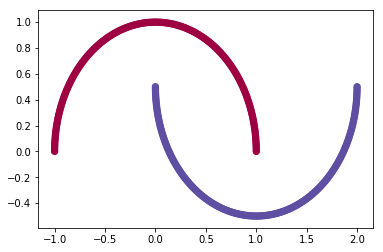

In [229]:

# DATA FOR CLASSIFICATION
# X, y = make_blobs(n_samples=400, centers=2, n_features=2, cluster_std=0.1,random_state=0)
X, y = make_moons(n_samples=400, shuffle=True, noise=None,random_state=0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

reshaped_y = np.array(y).reshape(len(y),1)

enc = OneHotEncoder()
enc.fit(reshaped_y)
encoded_y = enc.transform(reshaped_y).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.33, random_state=42)
# --------------------------
print(X_train[0])

In [230]:
net.train(X_train, y_train, 1000, minibatch_size=20)

Epoch: 0; Error: 7.335953781790577
Epoch: 1; Error: 6.415623415553222
Epoch: 2; Error: 6.863859839488366
Epoch: 3; Error: 5.628241406555832
Epoch: 4; Error: 5.986639792074397
Epoch: 5; Error: 5.530583907461768
Epoch: 6; Error: 5.4762345870422235
Epoch: 7; Error: 3.1083349889816
Epoch: 8; Error: 4.748710758602836
Epoch: 9; Error: 3.0398263441019417
Epoch: 10; Error: 3.4813157172541453
Epoch: 11; Error: 3.6837198454152786
Epoch: 12; Error: 2.777165946810262
Epoch: 13; Error: 3.4660994405624583
Epoch: 14; Error: 3.3766428720165327
Epoch: 15; Error: 3.1196934218168066
Epoch: 16; Error: 3.8446060726914313
Epoch: 17; Error: 3.892793386161407
Epoch: 18; Error: 2.730181125909997
Epoch: 19; Error: 2.688743026015017
Epoch: 20; Error: 2.9306077148023375
Epoch: 21; Error: 2.143341255143752
Epoch: 22; Error: 2.8475039255136054
Epoch: 23; Error: 4.078773226617597
Epoch: 24; Error: 2.6921365645414443
Epoch: 25; Error: 3.6772194666462656
Epoch: 26; Error: 2.8993312902076163
Epoch: 27; Error: 3.8557270

Epoch: 437; Error: 0.3356628609203799
Epoch: 438; Error: 0.48607283437936816
Epoch: 439; Error: 0.5650482903654682
Epoch: 440; Error: 0.6117321469179839
Epoch: 441; Error: 0.5193974710348004
Epoch: 442; Error: 0.8017829853336521
Epoch: 443; Error: 0.17293840823729062
Epoch: 444; Error: 0.22763115741385329
Epoch: 445; Error: 0.29103087652686904
Epoch: 446; Error: 0.20412735768394824
Epoch: 447; Error: 0.09243712047132512
Epoch: 448; Error: 0.3448466965621856
Epoch: 449; Error: 0.2992595190676174
Epoch: 450; Error: 0.42255862644015046
Epoch: 451; Error: 0.37793133649350863
Epoch: 452; Error: 0.5340846502154434
Epoch: 453; Error: 0.7513162654050332
Epoch: 454; Error: 0.3832854160005412
Epoch: 455; Error: 0.46415864356950737
Epoch: 456; Error: 0.3732477116663121
Epoch: 457; Error: 0.4560163336372559
Epoch: 458; Error: 0.4412285750488365
Epoch: 459; Error: 0.3125048229362434
Epoch: 460; Error: 0.09584445323556101
Epoch: 461; Error: 0.19445982242140158
Epoch: 462; Error: 0.20053804742920336


Epoch: 861; Error: 0.07480191174213821
Epoch: 862; Error: 0.16795813630266962
Epoch: 863; Error: 0.09236532915816793
Epoch: 864; Error: 0.11676919931296499
Epoch: 865; Error: 0.01855267943636992
Epoch: 866; Error: 0.24243782153523558
Epoch: 867; Error: 0.2545450923346252
Epoch: 868; Error: 0.214578226494696
Epoch: 869; Error: 0.06333406699327841
Epoch: 870; Error: 0.05723593364531733
Epoch: 871; Error: 0.017890738772150513
Epoch: 872; Error: 0.0937374384496078
Epoch: 873; Error: 0.08343973886075907
Epoch: 874; Error: 0.22799548559627825
Epoch: 875; Error: 0.04430306686037027
Epoch: 876; Error: 0.10284586180467883
Epoch: 877; Error: 0.11404468177218256
Epoch: 878; Error: 0.03693752204000533
Epoch: 879; Error: 0.14606872869922222
Epoch: 880; Error: 0.19801152408324574
Epoch: 881; Error: 0.29005863043958063
Epoch: 882; Error: 0.18334234448483866
Epoch: 883; Error: 0.09421890870722893
Epoch: 884; Error: 0.11226497333137234
Epoch: 885; Error: 0.10482057528562874
Epoch: 886; Error: 0.0434890